<a href="https://colab.research.google.com/github/PHastings37/Mphys-proj/blob/main/CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Using cpu device
/content/gdrive/My Drive/Mphys project/cancerdatasem2.csv
metadata_file path: /content/gdrive/My Drive/Mphys project/cancerdatasem2.csv
Length of metadata array is 100


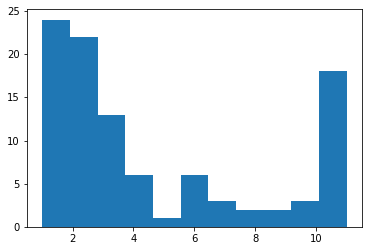

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [4, 32, 132, 132, 132]             288
         MaxPool3d-2        [4, 32, 66, 66, 66]               0
            Conv3d-3        [4, 64, 33, 33, 33]          16,448
         MaxPool3d-4        [4, 64, 16, 16, 16]               0
            Conv3d-5          [4, 128, 8, 8, 8]          65,664
         MaxPool3d-6          [4, 128, 4, 4, 4]               0
            Conv3d-7           [4, 64, 4, 4, 4]           8,256
            Conv3d-8           [4, 16, 4, 4, 4]           1,040
            Conv3d-9           [4, 11, 4, 4, 4]             187
        AvgPool3d-10           [4, 11, 1, 1, 1]               0
Total params: 91,883
Trainable params: 91,883
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 280.76
Forward/backward pass size (MB): 2607.44
Params size (MB): 0.35
Estimate

AttributeError: ignored

In [48]:
"""
This code trains, validates and tests a custom binary classfiying CNN.

The inputs to the network are 264 x 264 x 264 textured masks of NSCLC pre-treatment CT scans.

Rory Farwell and Patrick Hastings 08/02/2022

"""
#====================================================================
#======================= IMPORTING FUNCTIONS ========================
#====================================================================

# Un hash below if on Google Colab
!pip install torch torchvision
!pip install opencv-contrib-python
!pip install scikit-learn
!pip install SimpleITK

import numpy as np
import random
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch
import math

from mpl_toolkits.mplot3d import Axes3D
from torch.nn import Module
from torch.nn import Conv3d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import nn
from torch import reshape
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.io import read_image
from torch.optim import Adam
import torchvision.models as models
from torch.autograd import Variable
from torchsummary import summary

from scipy.ndimage import zoom, rotate

#====================================================================
#=================== COLAB SPECIFIC CODE ============================
#====================================================================

from google.colab import drive
drive.mount('/content/gdrive')

#====================================================================
#=================== SELECT DEVICE ==================================
#====================================================================

# Connect to GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
# /content/gdrive/MyDrive/MPhys/Data/COLAB-Clinical-Data.csv
# Specify project folder location
project_folder = "/content/gdrive/My Drive/Mphys project"
clinical_data_filename = "cancerdatasem2.csv"
print(os.path.join(project_folder, clinical_data_filename))

#====================================================================
#=================== DEFINING FUNCTIONS =============================
#====================================================================

def open_metadata() :
    """
    Opens the metadata file using the globall defined variables 'project_folder' and 'clinical_data_filename'.

    Returns patient_IDs which will be used for checking the data is shuffled
    Returns time_markers which will be used for checking patient status at a specified timepoint
    Returns dead_statuses.

    Rory Farwell and Patrick Hastings 08/02/2022
    """
    metadata_file = os.path.join(project_folder, clinical_data_filename)
    print(f'metadata_file path: {metadata_file}')
    metadata = np.genfromtxt(metadata_file, comments = '%', dtype="str", delimiter=",")
    print(f"Length of metadata array is {len(metadata)}")

    # Retrieve data from metadata file
    patient_IDs = metadata[:,0] # selecting patient IDs from the csv file
    time_markers = metadata[:,8] # selecting the day of the last patient review from the csv file
    dead_statuses = metadata[:,9] # selecting the dead status on the last review day

    time_markers = time_markers.astype(np.float32) # converting to float
    dead_statuses = dead_statuses.astype(np.float32) # converting to float

    return patient_IDs, time_markers, dead_statuses

def patient_label() :
    """
    Changes patient status according to patient status on the check day.

    here are the possible patient outcomes:
    1. Dead t=0 < time_to_death < incriment1   label = 0
    2. Dead incriment1 < time_to_death < incriment2   label = 1
    and so on up to 5 years, where at which point patient will be declared alive.
    Further to this patients who are right-censored will be counted as alive.

    Rory Farwell and Patrick Hastings 08/02/2022
    """

    dead_counter = 0
    alive_counter = 0
    no_info_counter = 0
    labels = np.empty(100)

    for i in range(len(dead_statuses)):

      if dead_statuses[i] == 1 and time_markers[i] < 1800: #check patient is dead before 1800 days(5 years)
        labels[i] = math.ceil(time_markers[i] / 180)
      else:
        
        labels[i] = 11

    return labels




def training_loop():
    epoch_train_loss = 0 # will be used for plotting testing vs validation loss curves
    n_training_samples = 0
    print(f'Training for epoch {epoch+1}')
    print("=============================")

    model.train()

    for i, (images, labels) in enumerate(train_dataloader):
        images = reshape(images, (images.shape[0], 1, 264, 264, 264))
        images = images.float()

        hot_labels = convert_to_one_hot_labels(images, labels)
        
        images = images.to(device)
        hot_labels = hot_labels.to(device)

        # print(hot_labels.size())
        # print(hot_labels)

   

        #forward pass
        outputs = model(images)
        # print (outputs)
        loss = criterion(outputs, hot_labels)

        #backwards pass
        optimizer.zero_grad() #clears gradients before performing backpropagation
        loss.backward()
        optimizer.step()

        # Add the number of images in this batch to n_training_samples which will
        # be used when calculating the average loss per image in the training set
        n_training_samples += labels.shape[0]

        # Updating the total training loss of this epoch
        all_training_losses.append(loss.item())
        epoch_train_loss += loss.item()

        if (i+1)%1 == 0 :
            print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

    # Append the train_loss list with the total training loss for this epoch
    train_loss.append(epoch_train_loss)

    #Append the avg_train_loss list with the average training loss of this epoch
    avg_train_loss = epoch_train_loss/n_training_samples
    print(f"Average training loss list: {avg_train_loss}")

    print(f"Training loss array at end of epoch {epoch + 1}: {train_loss}. Total number of images used = {n_training_samples}.")
    print(f"Finished training for epoch {epoch + 1}")

    return avg_train_loss

def validation_loop() :
    print(f'Validation for epoch {epoch + 1}')
    print('=================================')

    model.eval()

    with torch.no_grad(): # ensuring gradients are not calculated during the validation loop
        valid_epoch_loss = 0
        n_valid_correct = 0
        n_valid_samples = 0
        for images, labels in validation_dataloader :
            images = reshape(images, (images.shape[0],1 ,264,264,264))
            images = images.float()
            hot_labels = convert_to_one_hot_labels(images, labels)

            images = images.to(device)
            hot_labels = hot_labels.to(device)
            outputs = model(images)

            # calculate loss of validation set
            loss = criterion(outputs, hot_labels)
            valid_epoch_loss += loss.item()

            # max returns (value, index) 
            _,predictions = torch.max(outputs, 1)
            _,targets = torch.max(hot_labels, 1)
            #print(f'predictions: {predictions}')
            #print(f'targets: {targets}')
            #print(f'correct in this batch: {(predictions == targets).sum().item()}')
            n_valid_samples += labels.shape[0]
            n_valid_correct += (predictions == targets).sum().item()
            #print(f'n_correct = {n_correct}. n_samples = {n_samples}')
        avg_valid_loss = valid_epoch_loss/n_valid_samples
        #valid_loss.append(valid_epoch_loss)
        acc = (100*n_valid_correct)/n_valid_samples
        print(f'Accuracy on validation set for epoch {epoch+1} = {acc:.1f}%')
        print(f'Loss on validation set = {valid_epoch_loss}')

        print(f'Finished validation for epoch {epoch+1}')
        print('=============================================')
    return avg_valid_loss

def testing_loop():
  print("---- Currently testing the network on unseen data ----")
  model.eval()

  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    counter = 0
    for images, labels in test_dataloader :
      # counter+=1
      # print(counter)
      images = images = reshape(images, (images.shape[0],1 ,264,264,264))
      images = images.float()
      hot_labels = convert_to_one_hot_labels(images, labels)

      images = images.to(device)
      hot_labels = hot_labels.to(device)
      outputs = model(images)
      # max returns (value, index) 
      _,predictions = torch.max(outputs, 1)
      _,targets = torch.max(hot_labels,1)
      #print(f'predictions: {predictions}')
      #print(f'targets: {targets}')
      n_samples += hot_labels.shape[0]
      n_correct += (predictions == targets).sum().item()
      #print(f'n_correct = {n_correct}. n_samples = {n_samples}')
    
    acc = (100*n_correct)/n_samples

    return acc

def plot_loss_curves() :
  new_avg_train_loss = avg_train_loss
  new_avg_valid_loss = avg_valid_loss

  epochs = np.array(range(num_epochs)) + 1
  fig = plt.figure()
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  fig.set_size_inches(20, 10)
  plt.plot(epochs, new_avg_train_loss, label = 'Average training loss',linewidth=7.0)
  plt.plot(epochs, new_avg_valid_loss, label = 'Average validation loss',linewidth=7.0)
  plt.legend(loc='best', prop={'size': 20})
  plt.ylabel('Average Loss', fontsize = 20)
  plt.xlabel('Epoch Number', fontsize = 20)
  plt.show()
  return

def window_and_level(image, level = 700, window = 1000) :
  maxval = level + window/2
  minval = level - window/2
  wld = np.clip(image, minval, maxval)
  wld -=minval
  wld *= 1/window
  return wld


#====================================================================
#=================  CLASS DEFINITIONS ===============================
#====================================================================

# Normalize class added 12/12/2021
class Normalize():
  def __init__(self):
    pass

  def __call__(self,vol):
    vol =((vol-(vol.mean()))/vol.std()) + 1
    return vol

transform = transforms.Compose(
    [transforms.ToTensor()] #added 13/12/2021 to normalize the inputs. THIS NORMALIZES to mean = 0 and std = 1
)


class ImageDataset(Dataset) :
  def __init__(self, annotations, img_dir, transform = transform, target_transform = None, shift_augment = True, rotate_augment = True, scale_augment = True, flip_augment = True) :
    self.img_labels = annotations
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
    self.shifts = shift_augment
    self.rotations = rotate_augment
    self.flips = flip_augment
    self.scales = scale_augment

  def __len__(self) :
    return len(self.img_labels)

  def __getitem__(self,idx) :
    img_path = os.path.join(self.img_dir, self.img_labels[idx][0] + "-GTV-1.nii" )
    image_sitk = sitk.ReadImage(img_path)
    # ID = self.img_labels[idx][0]
    # print(f'ID: {ID}')
    image = sitk.GetArrayFromImage(image_sitk)
    label = self.img_labels[idx][1]

    # Augmentations
    if self.shifts:
      mx_x, mx_yz = 10, 10 
      # find shift values
      cc_shift, ap_shift, lr_shift = random.randint(-mx_x,mx_x), random.randint(-mx_yz,mx_yz), random.randint(-mx_yz,mx_yz)
      # pad for shifting into
      image = np.pad(image, pad_width=((mx_x,mx_x),(mx_yz,mx_yz),(mx_yz,mx_yz)), mode='constant', constant_values=0)
      # crop to complete shift
      image = image[mx_x+cc_shift:264+mx_x+cc_shift, mx_yz+ap_shift:264+mx_yz+ap_shift, mx_yz+lr_shift:264+mx_yz+lr_shift]

    if self.rotations and random.random() < 0.5 :
      roll_angle = np.clip(np.random.normal(loc=0,scale=3), -10, 10)
      image = self.rotation(image, roll_angle, rotation_plane=(1,2))

    if self.scales and random.random() < 0.5 :
      # same here -> zoom between 80-120%
      scale_factor = np.clip(np.random.normal(loc=1.0,scale=0.05), 0.8, 1.2)
      image = self.scale(image, scale_factor)
    
    image = window_and_level(image)

    if self.transform :
      image = self.transform(image)
    if self.target_transform :
      label = self.target_transform(label)
    return image,label
  
  def rotation(self, image, rotation_angle, rotation_plane):
      # rotate the image or mask using scipy rotate function
      order, cval = (3, -1024)
      return rotate(input=image, angle=rotation_angle, axes=rotation_plane, reshape=False, order=order, mode='constant', cval=cval)
    
  def scale(self, image, scale_factor):
      # scale the image or mask using scipy zoom function
      order, cval = (3, -1024)
      height, width, depth = image.shape
      zheight = int(np.round(scale_factor*height))
      zwidth = int(np.round(scale_factor*width))
      zdepth = int(np.round(scale_factor*depth))
      # zoomed out
      if scale_factor < 1.0:
          new_image = np.full_like(image, cval)
          ud_buffer = (height-zheight) // 2
          ap_buffer = (width-zwidth) // 2
          lr_buffer = (depth-zdepth) // 2
          new_image[ud_buffer:ud_buffer+zheight, ap_buffer:ap_buffer+zwidth, lr_buffer:lr_buffer+zdepth] = zoom(input=image, zoom=scale_factor, order=order, mode='constant', cval=cval)[0:zheight, 0:zwidth, 0:zdepth]
          return new_image
      elif scale_factor > 1.0:
          new_image = zoom(input=image, zoom=scale_factor, order=order, mode='constant', cval=cval)[0:zheight, 0:zwidth, 0:zdepth]
          ud_extra = (new_image.shape[0] - height) // 2
          ap_extra = (new_image.shape[1] - width) // 2
          lr_extra = (new_image.shape[2] - depth) // 2
          new_image = new_image[ud_extra:ud_extra+height, ap_extra:ap_extra+width, lr_extra:lr_extra+depth]
          return new_image
      return image

class CNN(nn.Module):   
    def __init__(self):
        super(CNN, self).__init__()
        # self.conv1 = nn.Conv3d(1,4,2,2)
        # self.pool = nn.MaxPool3d(2,2)
        # self.avg_pool = nn.AvgPool3d(2)
        # self.conv2 = nn.Conv3d(4,16,2,2)
        # self.conv3 = nn.Conv3d(16,64,2,2)
        # self.conv4 = nn.Conv3d(64,256,2,2)
        # self.dropout = nn.Dropout(0.25)
        # self.fc1 = nn.Linear(256,64)
        # self.fc2 = nn.Linear(64,16)
        # self.fc3 = nn.Linear(16,2)

    # def __init__(self):
    #     super(CNN, self).__init__()
        # self.conv1 = nn.Conv3d(1,16,2,2)
        # self.pool = nn.MaxPool3d(2,2)
        # self.avg_pool = nn.AvgPool3d(2)
        # self.conv2 = nn.Conv3d(16,16,2,2)
        # self.conv3 = nn.Conv3d(16,16,2,2)
        # self.conv4 = nn.Conv3d(16,8,2,2)
        # self.dropout = nn.Dropout(0.25)
        # self.fc1 = nn.Linear(16,64)
        # self.fc2 = nn.Linear(64,16)
        # self.fc3 = nn.Linear(16,2)

    def __init__(self):
      super(CNN, self).__init__()
      self.conv1 = nn.Conv3d(1,32,2,2)
      self.pool = nn.MaxPool3d(2,2)
      self.avg_pool = nn.AvgPool3d(4)
      self.conv2 = nn.Conv3d(32,64,2,2)
      self.conv3 = nn.Conv3d(64,128,2,2)
      self.conv4 = nn.Conv3d(128,64,1,1)
      self.conv5 = nn.Conv3d(64,16,1,1)
      self.conv6 = nn.Conv3d(16,11,1,1)

    # Defining the forward pass    (original)
    # def forward(self, x):
    #     print(f'Input to the network: {x}')
    #     x = self.pool(F.leaky_relu(self.conv1(x)))
    #     x = self.pool(F.leaky_relu(self.conv2(x)))
    #     x = self.pool(F.leaky_relu(self.conv3(x)))
    #     x = self.avg_pool(F.leaky_relu(self.conv4(x)))
    #     print(f'After average pooling layer: {x}')
    #     x = x.view(-1, 16)
    #     print(f'After flattening: {x}')
    #     x = self.dropout(x)
    #     x = F.leaky_relu(self.fc1(x))
    #     x = self.dropout(x)
    #     x = F.leaky_relu(self.fc2(x))
        
    #     x = self.dropout(x)
        
    #     x = self.fc3(x)
    #     print(x)
    #     return x

    # Defining the forward pass  (NIN method)  
    def forward(self, x):
        #print(f'Input to the network: {x}')
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        #print(f'Before the weird conv layers: {x}')
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = self.avg_pool(self.conv6(x))
        #print(f'After the average pooling function: {x}')
        x = x.view(-1,11)
        
        
        return x
        
model = CNN().to(device) # Send the CNN to the device




#====================================================================
#=================== DEFIINING VARIABLES ============================
#====================================================================


# sanity check to check progress
counter = 0 


# Creating empty arrays that will be appended to later
# These will contain the patient ID and dead status (on the check day).
training_array = []
testing_array = []
validation_array = []

#====================================================================
#=================== HYPER PARAMETER DEFINITION =====================
#====================================================================
batch_size = 4
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epochs = 8

#====================================================================
#=================== MAIN CODE ======================================
#====================================================================

patient_labels = []
patient_IDs, time_markers, dead_statuses = open_metadata()#gathers patient data
patient_labels = patient_label()#assigns each patients a label based on survial time

patient_labels = np.reshape(patient_labels, [100, 1])
patient_IDs = np.reshape(patient_IDs, [100, 1])
comb_array = np.hstack((patient_IDs, patient_labels))#creates one 2d array where each row is a patient and its corresponding label
comb_array = comb_array.tolist()



plt.hist(patient_labels, bins = 11)
plt.show()

full_dataset = ImageDataset(comb_array, os.path.join(project_folder, "Textured_Masks"), transform = transform)

training_data, validation_data, test_data = torch.utils.data.random_split(full_dataset, [70,15,15])



train_dataloader = DataLoader(training_data, batch_size = 4, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 4, shuffle = False)
validation_dataloader = DataLoader(validation_data, batch_size = 4, shuffle = True)

summary(model, (1,264,264,264), batch_size = 4)

#============================ TRAINING AND VALIDATION LOOP ==========
n_total_steps = len(train_dataloader)
train_loss = []
valid_loss = []
avg_train_loss = np.empty(0)
avg_valid_loss = np.empty(0)
all_training_losses = []

for epoch in range(num_epochs):
    avg_train_loss = np.append(avg_train_loss, training_loop())
    avg_valid_loss = np.append(avg_valid_loss, validation_loop())

print('FINISHED TRAINING')
print(f'All training batch losses = {all_training_losses}')
print(f'Training losses = {train_loss}')
print(f'Average training losses = {avg_train_loss}')
print(f'Validation losses = {avg_valid_loss}')

#===================== PLOT LOSS CURVES =============================
plot_loss_curves()

#===================== TESTING LOOP =================================
testing_accuracy = testing_loop()
print(f'Accuracy on testing set = {testing_accuracy:.1f}%')


In [35]:
patient_labels = np.reshape(patient_labels, [100, 1])
patient_IDs = np.reshape(patient_IDs, [100, 1])

comb_array = np.hstack((patient_IDs, patient_labels))

In [ ]:
print(trainset)